# Diagonsis and DIA (Data Inspection Assistant)

If you cannot import this module, please try: pip install "polars_ds[plot]"

The dataset is downloaded on github.

In [1]:
import polars as pl
import polars_ds as pds

In [2]:
df = pds.random_data(size=100_000, n_cols = 0).select(
    pds.random(0.0, 12.0).alias("uniform_1"),
    pds.random(0.0, 1.0).alias("uniform_2"),
    pds.random_exp(0.5).alias("exp"),
    pds.random_normal(0.0, 1.0).alias("normal"),
    pds.random_normal(0.0, 1000.0).alias("fat_normal"),
)
df.head()

uniform_1,uniform_2,exp,normal,fat_normal
f64,f64,f64,f64,f64
4.924138,0.841042,0.0502,-1.434,-373.867134
3.310628,0.71762,7.291828,-1.059625,216.096009
3.445506,0.94846,1.415297,2.08192,581.965509
5.107332,0.451167,2.940701,1.143958,-474.329596
10.130584,0.465351,3.156858,-2.63732,2336.558146


In [3]:
from polars_ds.diagnosis import DIA
dia = DIA(df)

In [4]:
dia.numeric_profile(n_bins=15)

GT(_tbl_data=shape: (5, 13)
┌────────────┬────────────┬───────┬───────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ column     ┆ non_null_c ┆ null% ┆ mean      ┆ … ┆ max        ┆ IQR       ┆ outlier_c ┆ histogram │
│ ---        ┆ nt         ┆ ---   ┆ ---       ┆   ┆ ---        ┆ ---       ┆ nt        ┆ ---       │
│ str        ┆ ---        ┆ f64   ┆ f64       ┆   ┆ f64        ┆ f64       ┆ ---       ┆ struct[1] │
│            ┆ u32        ┆       ┆           ┆   ┆            ┆           ┆ u32       ┆           │
╞════════════╪════════════╪═══════╪═══════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ uniform_1  ┆ 100000     ┆ 0.0   ┆ 5.990977  ┆ … ┆ 11.999806  ┆ 6.03547   ┆ 0         ┆ {[6685,   │
│            ┆            ┆       ┆           ┆   ┆            ┆           ┆           ┆ 6733, …   │
│            ┆            ┆       ┆           ┆   ┆            ┆           ┆           ┆ 6633]}    │
│ uniform_2  ┆ 100000     ┆ 0.0   ┆ 0.499895  ┆ … ┆ 0.999997   ┆ 0.497996  ┆ 0         ┆ {[6697,   │
│            ┆            ┆       ┆           ┆   ┆            ┆           ┆           ┆ 6666, …   │
│            ┆            ┆       ┆           ┆   ┆            ┆           ┆           ┆ 6550]}    │
│ exp        ┆ 100000     ┆ 0.0   ┆ 2.005147  ┆ … ┆ 22.256079  ┆ 2.195901  ┆ 4929      ┆ {[52408,  │
│            ┆            ┆       ┆           ┆   ┆            ┆           ┆           ┆ 24853, …  │
│            ┆            ┆       ┆           ┆   ┆            ┆           ┆           ┆ 2]}       │
│ normal     ┆ 100000     ┆ 0.0   ┆ -0.000203 ┆ … ┆ 4.631733   ┆ 1.35539   ┆ 660       ┆ {[33,     │
│            ┆            ┆       ┆           ┆   ┆            ┆           ┆           ┆ 190, …    │
│            ┆            ┆       ┆           ┆   ┆            ┆           ┆           ┆ 6]}       │
│ fat_normal ┆ 100000     ┆ 0.0   ┆ 3.703789  ┆ … ┆ 4685.00714 ┆ 1345.2174 ┆ 687       ┆ {[48,     │
│            ┆            ┆       ┆           ┆   ┆ 5          ┆ 88        ┆           ┆ 281, …    │
│            ┆            ┆       ┆           ┆   ┆            ┆           ┆           ┆ 4]}       │
└────────────┴────────────┴───────┴───────────┴───┴────────────┴───────────┴───────────┴───────────┘, _body=<great_tables._gt_data.Body object at 0x7785c0757e50>, _boxhead=Boxhead([ColInfo(var='column', type=<ColInfoTypeEnum.stub: 2>, column_label='column', column_align='left', column_width=None), ColInfo(var='non_null_cnt', type=<ColInfoTypeEnum.default: 1>, column_label='non_null_cnt', column_align='center', column_width=None), ColInfo(var='null%', type=<ColInfoTypeEnum.default: 1>, column_label='null%', column_align='right', column_width=None), ColInfo(var='mean', type=<ColInfoTypeEnum.default: 1>, column_label='mean', column_align='right', column_width=None), ColInfo(var='std', type=<ColInfoTypeEnum.default: 1>, column_label='std', column_align='right', column_width=None), ColInfo(var='min', type=<ColInfoTypeEnum.default: 1>, column_label='min', column_align='right', column_width=None), ColInfo(var='q1', type=<ColInfoTypeEnum.default: 1>, column_label='q1', column_align='right', column_width=None), ColInfo(var='median', type=<ColInfoTypeEnum.default: 1>, column_label='median', column_align='right', column_width=None), ColInfo(var='q3', type=<ColInfoTypeEnum.default: 1>, column_label='q3', column_align='right', column_width=None), ColInfo(var='max', type=<ColInfoTypeEnum.default: 1>, column_label='max', column_align='right', column_width=None), ColInfo(var='IQR', type=<ColInfoTypeEnum.default: 1>, column_label='IQR', column_align='right', column_width=None), ColInfo(var='outlier_cnt', type=<ColInfoTypeEnum.default: 1>, column_label='outlier_cnt', column_align='center', column_width=None), ColInfo(var='histogram', type=<ColInfoTypeEnum.default: 1>, column_label='histogram', column_align='center', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id=None, rowname='uniform_1', group_label=None, built=False), R

In [5]:
dia.infer_corr()

x,y,corr
str,str,f64
"""uniform_2""","""normal""",-0.004531
"""uniform_1""","""exp""",0.004239
"""uniform_1""","""uniform_2""",0.003181
"""uniform_1""","""fat_normal""",-0.002994
"""exp""","""normal""",0.002449
"""normal""","""fat_normal""",-0.002354
"""uniform_1""","""normal""",0.001279
"""uniform_2""","""exp""",0.000997
"""uniform_2""","""fat_normal""",-0.000733


# Dependency Detection

Does knowing values in column A tell us values in column B?

In [6]:
df = pl.read_parquet("dependency.parquet")
df.head()

ID,Gender,DOB,Lead_Creation_Date,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,Customer_Existing_Primary_Bank_Code,Primary_Bank_Type,Contacted,Source,Source_Category,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved
str,str,str,str,str,str,str,str,i64,f64,str,str,str,str,str,f64,i64,i64,f64,i64,i64,i64
"""APPC9049317122…","""Female""","""23/07/79""","""15/07/16""","""C10001""","""A""","""COM0044082""","""A""",4,2000.0,"""B001""","""P""","""N""","""S122""","""G""",0.0,null,null,null,null,0,0
"""APPD4061126334…","""Male""","""07/12/86""","""04/07/16""","""C10003""","""A""","""COM0000002""","""C""",1,3500.0,"""B002""","""P""","""Y""","""S122""","""G""",0.0,20000,2,13.25,953,10,0
"""APPE7028924942…","""Male""","""10/12/82""","""19/07/16""","""C10125""","""C""","""COM0005267""","""C""",4,2250.0,"""B003""","""G""","""Y""","""S143""","""B""",0.0,45000,4,null,null,0,0
"""APPF8027386553…","""Male""","""30/01/89""","""09/07/16""","""C10477""","""C""","""COM0004143""","""A""",4,3500.0,"""B003""","""G""","""Y""","""S143""","""B""",0.0,92000,5,null,null,7,0
"""APPG6099443664…","""Male""","""19/04/85""","""20/07/16""","""C10002""","""A""","""COM0001781""","""A""",4,10000.0,"""B001""","""P""","""Y""","""S134""","""B""",2500.0,50000,2,null,null,10,0


In [7]:
dia = DIA(df)

In [8]:
dia.infer_dependency()

INFO:polars_ds.diagnosis:Running dependency for columns: ['Approved', 'Gender', 'Contacted', 'Primary_Bank_Type', 'City_Category', 'Employer_Category1', 'Employer_Category2', 'Var1', 'Loan_Period', 'Source_Category', 'Source', 'Customer_Existing_Primary_Bank_Code', 'Lead_Creation_Date', 'Loan_Amount', 'City_Code', 'EMI', 'DOB', 'Employer_Code', 'ID'].


column,by,cond_entropy
str,str,f64
"""Approved""","""ID""",0.0
"""Gender""","""ID""",0.0
"""Contacted""","""ID""",0.0
"""Primary_Bank_T…","""Customer_Exist…",0.0
"""Primary_Bank_T…","""ID""",0.0
…,…,…
"""Loan_Amount""","""City_Code""",2.702889
"""City_Code""","""EMI""",3.147327
"""Lead_Creation_…","""EMI""",3.92818


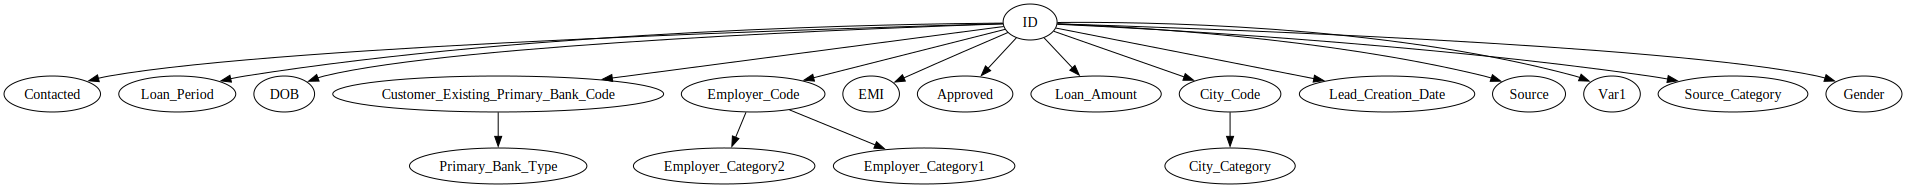

In [9]:
dia.plot_dependency()

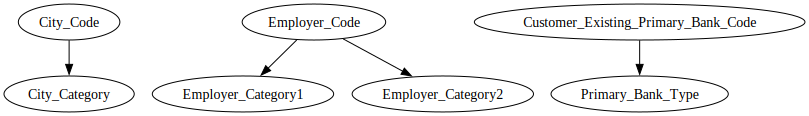

In [10]:
# ID implies everything, of course, because ID is unique.
# So let's not plot it
dia.plot_dependency(exclude=["ID"])

In [11]:
dia.str_stats()

column,null_count,n_unique,most_freq,most_freq_cnt,min_byte_len,min_char_len,avg_byte_len,avg_char_len,max_byte_len,max_char_len,5p_byte_len,95p_byte_len
str,u32,u32,str,u32,u32,u32,f64,f64,u32,u32,f64,f64
"""ID""",0,69713,"""APPC9049317122…",1,15,15,15.0,15.0,15,15,15.0,15.0
"""Gender""",0,2,"""Male""",39949,4,4,4.853901,4.853901,6,6,4.0,6.0
"""DOB""",15,10760,"""11/01/82""",253,8,8,8.0,8.0,8,8,8.0,8.0
"""Lead_Creation_…",0,92,"""02/09/16""",1838,8,8,8.0,8.0,8,8,8.0,8.0
"""City_Code""",814,679,"""C10001""",10007,6,6,6.0,6.0,6,6,6.0,6.0
…,…,…,…,…,…,…,…,…,…,…,…,…
"""Customer_Exist…",9391,58,"""B001""",14197,4,4,4.0,4.0,4,4,4.0,4.0
"""Primary_Bank_T…",9391,3,"""P""",39619,1,1,1.0,1.0,1,1,1.0,1.0
"""Contacted""",0,2,"""Y""",45275,1,1,1.0,1.0,1,1,1.0,1.0


In [12]:
dia.numeric_profile(iqr_multiplier=2)

GT(_tbl_data=shape: (9, 13)
┌────────────┬────────────┬──────────┬────────────┬───┬──────────┬─────────┬───────────┬───────────┐
│ column     ┆ non_null_c ┆ null%    ┆ mean       ┆ … ┆ max      ┆ IQR     ┆ outlier_c ┆ histogram │
│ ---        ┆ nt         ┆ ---      ┆ ---        ┆   ┆ ---      ┆ ---     ┆ nt        ┆ ---       │
│ str        ┆ ---        ┆ f64      ┆ f64        ┆   ┆ f64      ┆ f64     ┆ ---       ┆ struct[1] │
│            ┆ u32        ┆          ┆            ┆   ┆          ┆         ┆ u32       ┆           │
╞════════════╪════════════╪══════════╪════════════╪═══╪══════════╪═════════╪═══════════╪═══════════╡
│ Employer_C ┆ 65415      ┆ 0.061653 ┆ 3.720187   ┆ … ┆ 4.0      ┆ 0.0     ┆ 7833      ┆ {[4298,   │
│ ategory2   ┆            ┆          ┆            ┆   ┆          ┆         ┆           ┆ 4258, …   │
│            ┆            ┆          ┆            ┆   ┆          ┆         ┆           ┆ 57582]}   │
│ Monthly_In ┆ 69713      ┆ 0.0      ┆ 5622.2832  ┆ … ┆ 3.8384e7 ┆ 2350.0  ┆ 3920      ┆ {[69699,  │
│ come       ┆            ┆          ┆            ┆   ┆          ┆         ┆           ┆ 5, … 1]}  │
│ Existing_E ┆ 69662      ┆ 0.000732 ┆ 360.928751 ┆ … ┆ 545436.5 ┆ 350.0   ┆ 6549      ┆ {[69655,  │
│ MI         ┆            ┆          ┆            ┆   ┆          ┆         ┆           ┆ 5, … 1]}  │
│ Loan_Amoun ┆ 42004      ┆ 0.397472 ┆ 39429.9828 ┆ … ┆ 300000.0 ┆ 30000.0 ┆ 1547      ┆ {[27709,  │
│ t          ┆            ┆          ┆ 59         ┆   ┆          ┆         ┆           ┆ 8646, …   │
│            ┆            ┆          ┆            ┆   ┆          ┆         ┆           ┆ 4]}       │
│ Loan_Perio ┆ 42004      ┆ 0.397472 ┆ 3.890629   ┆ … ┆ 6.0      ┆ 2.0     ┆ 0         ┆ {[27709,  │
│ d          ┆            ┆          ┆            ┆   ┆          ┆         ┆           ┆ 1886, …   │
│            ┆            ┆          ┆            ┆   ┆          ┆         ┆           ┆ 1]}       │
│ Interest_R ┆ 22276      ┆ 0.680461 ┆ 19.21357   ┆ … ┆ 37.0     ┆ 4.75    ┆ 2378      ┆ {[758,    │
│ ate        ┆            ┆          ┆            ┆   ┆          ┆         ┆           ┆ 2752, …   │
│            ┆            ┆          ┆            ┆   ┆          ┆         ┆           ┆ 240]}     │
│ EMI        ┆ 22276      ┆ 0.680461 ┆ 1101.46624 ┆ … ┆ 13556.0  ┆ 646.0   ┆ 1081      ┆ {[47437,  │
│            ┆            ┆          ┆ 2          ┆   ┆          ┆         ┆           ┆ 8179, …   │
│            ┆            ┆          ┆            ┆   ┆          ┆         ┆           ┆ 2]}       │
│ Var1       ┆ 69713      ┆ 0.0      ┆ 3.948446   ┆ … ┆ 10.0     ┆ 7.0     ┆ 0         ┆ {[23308,  │
│            ┆            ┆          ┆            ┆   ┆          ┆         ┆           ┆ 13363, …  │
│            ┆            ┆          ┆            ┆   ┆          ┆         ┆           ┆ 13420]}   │
│ Approved   ┆ 69713      ┆ 0.0      ┆ 0.014631   ┆ … ┆ 1.0      ┆ 0.0     ┆ 1020      ┆ {[68693,  │
│            ┆            ┆          ┆            ┆   ┆          ┆         ┆           ┆ 1020]}    │
└────────────┴────────────┴──────────┴────────────┴───┴──────────┴─────────┴───────────┴───────────┘, _body=<great_tables._gt_data.Body object at 0x7785a81a2610>, _boxhead=Boxhead([ColInfo(var='column', type=<ColInfoTypeEnum.stub: 2>, column_label='column', column_align='left', column_width=None), ColInfo(var='non_null_cnt', type=<ColInfoTypeEnum.default: 1>, column_label='non_null_cnt', column_align='center', column_width=None), ColInfo(var='null%', type=<ColInfoTypeEnum.default: 1>, column_label='null%', column_align='right', column_width=None), ColInfo(var='mean', type=<ColInfoTypeEnum.default: 1>, column_label='mean', column_align='right', column_width=None), ColInfo(var='std', type=<ColInfoTypeEnum.default: 1>, column_label='std', column_align='right', column_width=None), ColInfo(var='min', type=<ColInfoTypeEnum.default: 1>, column_label='min', column_align='right', column_width=None), ColInfo(var='q1', type=<ColInfoTypeEnu

In [13]:
import polars.selectors as cs

dia.corr(subset=["Monthly_Income", "Existing_EMI"])

column,Employer_Category2,Monthly_Income,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Monthly_Income…",0.001546,1.0,0.245826,0.039998,-0.003671,-0.014789,0.035163,0.024854,0.000472
"""Existing_EMI""",-0.017074,0.245826,1.0,0.008653,-0.004603,-0.023001,0.000813,0.00662,0.027821


In [14]:
dia.corr(subset=cs.all())

INFO:polars_ds.diagnosis:The following columns are not numeric/not in the dataframe, skipped: 
['Contacted', 'Primary_Bank_Type', 'Employer_Code', 'ID', 'DOB', 'Gender', 'Lead_Creation_Date', 'Customer_Existing_Primary_Bank_Code', 'Source_Category', 'City_Category', 'Source', 'Employer_Category1', 'City_Code']


column,Employer_Category2,Monthly_Income,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Employer_Categ…",1.0,0.001546,-0.017074,-0.061479,-0.007449,0.177605,-0.051729,-0.124415,-0.019413
"""Monthly_Income…",0.001546,1.0,0.245826,0.039998,-0.003671,-0.014789,0.035163,0.024854,0.000472
"""Existing_EMI""",-0.017074,0.245826,1.0,0.008653,-0.004603,-0.023001,0.000813,0.00662,0.027821
"""Loan_Amount""",-0.061479,0.039998,0.008653,1.0,0.379921,-0.321095,0.916832,0.307945,0.046502
"""Loan_Period""",-0.007449,-0.003671,-0.004603,0.379921,1.0,-0.096629,0.083965,-0.065702,-0.000375
"""Interest_Rate""",0.177605,-0.014789,-0.023001,-0.321095,-0.096629,1.0,-0.241648,-0.554138,-0.094387
"""EMI""",-0.051729,0.035163,0.000813,0.916832,0.083965,-0.241648,1.0,0.293474,0.050129
"""Var1""",-0.124415,0.024854,0.00662,0.307945,-0.065702,-0.554138,0.293474,1.0,0.11244
"""Approved""",-0.019413,0.000472,0.027821,0.046502,-0.000375,-0.094387,0.050129,0.11244,1.0


In [15]:
dia.plot_corr(subset=["Monthly_Income", "Existing_EMI"])

column,Employer_Category2,Monthly_Income,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved
Monthly_Income,0.002,1.000,0.246,0.040,−0.004,−0.015,0.035,0.025,0.000
Existing_EMI,−0.017,0.246,1.000,0.009,−0.005,−0.023,0.001,0.007,0.028


In [16]:
dia.plot_corr(subset=cs.all())

INFO:polars_ds.diagnosis:The following columns are not numeric/not in the dataframe, skipped: 
['Contacted', 'Primary_Bank_Type', 'Employer_Code', 'ID', 'DOB', 'Gender', 'Lead_Creation_Date', 'Customer_Existing_Primary_Bank_Code', 'Source_Category', 'City_Category', 'Source', 'Employer_Category1', 'City_Code']


column,Employer_Category2,Monthly_Income,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved
Employer_Category2,1.000,0.002,−0.017,−0.061,−0.007,0.178,−0.052,−0.124,−0.019
Monthly_Income,0.002,1.000,0.246,0.040,−0.004,−0.015,0.035,0.025,0.000
Existing_EMI,−0.017,0.246,1.000,0.009,−0.005,−0.023,0.001,0.007,0.028
Loan_Amount,−0.061,0.040,0.009,1.000,0.380,−0.321,0.917,0.308,0.047
Loan_Period,−0.007,−0.004,−0.005,0.380,1.000,−0.097,0.084,−0.066,−0.000
Interest_Rate,0.178,−0.015,−0.023,−0.321,−0.097,1.000,−0.242,−0.554,−0.094
EMI,−0.052,0.035,0.001,0.917,0.084,−0.242,1.000,0.293,0.050
Var1,−0.124,0.025,0.007,0.308,−0.066,−0.554,0.293,1.000,0.112
Approved,−0.019,0.000,0.028,0.047,−0.000,−0.094,0.050,0.112,1.000
